# **PREDICTING TRADING VOLUME WITH DIFFERENT NEURAL NETWORK ARCHITECTURES**

Workflow:

- Prep:
  - Treating Non-Stationarity: 
    - rolling averages to reduce noise 
    - differencing and log_trafo to make the data stationary
  - Min-Max Scaling for better convergence
  - Kernel PCA for dimensionality reduction
  - Creating sequences of past observed Predictors and Target Variable as input (Autoregressive Multivariate many to one Timeseries)
- Modeling:
  - Feedforward, Recurrent, Gated-Recurrent-Unit and Long-Term-Short-Term Neural-Net Layers to predict one timestep ahead


# Setup
The dataset contains 320 latent features generated from the original time series of a certain asset. The last column in the train dataset is the target variable, which is the one day-ahead trading volume. (Data from https://github.com/Humboldt-WI/delta)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.metrics import (mean_squared_error, mean_absolute_error)

from statsmodels.tsa.stattools import (pacf, adfuller)

from math import sqrt

import tensorflow as tf
import keras




SEED = 123

In [3]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignments/Train_Time_Series.csv')

df.head()

,Date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,Trading Volume (Target Variable)
0,0,1.296695e+10,1.457547e+10,1.325288e+09,-2.655211e+10,2.101698e+10,-9.094024e+09,4.858148e+09,-2.356104e+09,-3.233936e+10,...,-1.644660e+10,9.440106e+09,1.541441e+10,1.119134e+10,4.934779e+09,-1.751067e+09,5.676475e+09,3.468865e+10,-2.065788e+10,7780059.06
1,1,1.296838e+10,1.457465e+10,1.328991e+09,-2.655095e+10,2.115096e+10,-9.086957e+09,4.913736e+09,-2.354550e+09,-3.234193e+10,...,-1.773644e+10,9.416437e+09,1.545443e+10,1.118869e+10,4.936015e+09,-1.749437e+09,5.694470e+09,3.467851e+10,-2.066140e+10,7454553.80
2,2,1.305118e+10,1.463240e+10,1.306612e+09,-2.651588e+10,2.114048e+10,-9.094517e+09,4.919696e+09,-2.304025e+09,-3.232356e+10,...,-1.761549e+10,9.425556e+09,1.552926e+10,1.119478e+10,4.963428e+09,-1.776820e+09,5.702848e+09,3.468841e+10,-2.067423e+10,29459968.91
3,3,1.381830e+10,1.516195e+10,1.151668e+09,-2.651554e+10,2.114120e+10,-9.052058e+09,4.983555e+09,-1.998877e+09,-3.232600e+10,...,-1.756951e+10,9.640630e+09,1.571777e+10,1.107390e+10,5.225323e+09,-2.073629e+09,5.731859e+09,3.500143e+10,-2.045206e+10,13630323.78
4,4,1.376322e+10,1.527571e+10,1.281023e+09,-2.670474e+10,2.122595e+10,-9.091410e+09,5.032221e+09,-2.144453e+09,-3.253045e+10,...,-1.753090e+10,9.775995e+09,1.571977e+10,1.129186e+10,5.128488e+09,-2.067993e+09,5.317616e+09,3.692245e+10,-2.049799e+10,9224729.90


In [4]:
X = df.drop('Trading Volume (Target Variable)', axis=1)
y = df['Trading Volume (Target Variable)'].copy().to_numpy().reshape(-1, 1)

print(X.shape,y.shape)

(2103, 321) (2103, 1)


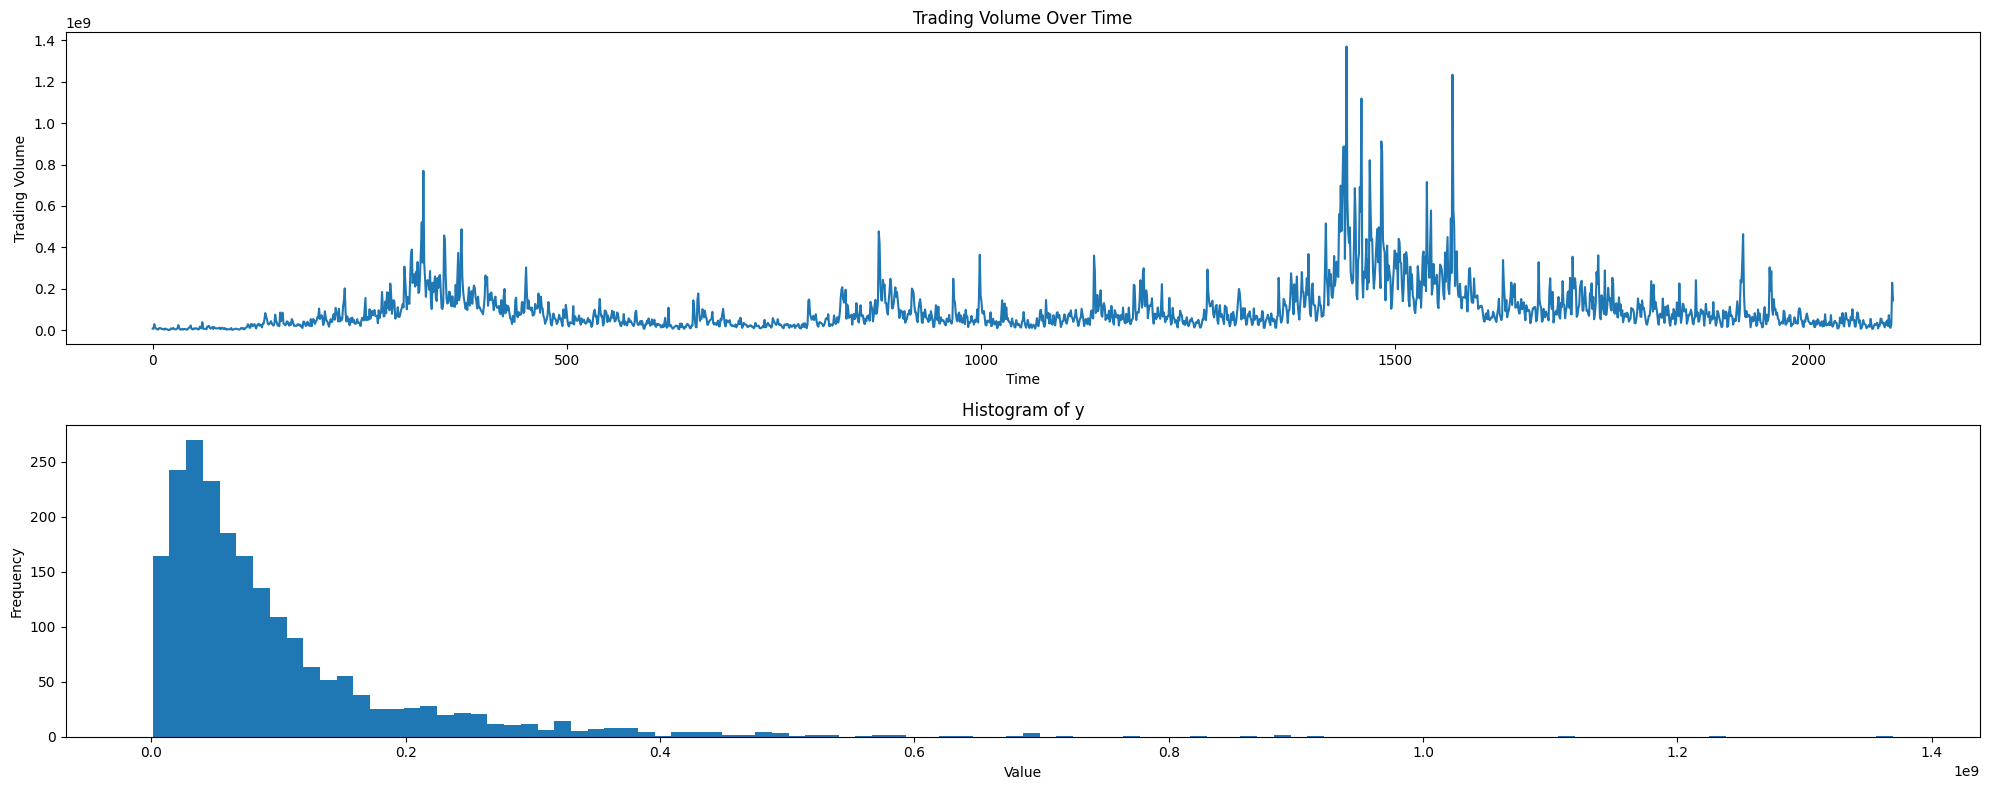

In [5]:
fig, (ax1, ax2) = plt.subplots (2, 1, figsize=(20, 8))

# Plot Trading Volume (Target Variable)
ax1.plot(y)
ax1.set_title('Trading Volume Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Trading Volume')

# Plot histogram of y
ax2.hist(y, bins='auto')
ax2.set_title('Histogram of y')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date                                0
0                                   0
1                                   0
2                                   0
3                                   0
                                   ..
316                                 0
317                                 0
318                                 0
319                                 0
Trading Volume (Target Variable)    0
Length: 322, dtype: int64


# PREP

In [7]:
# NN-PARAMS
UNITS = 30 # Neurons in a Layer
EPOCHS = 100 # Number of epochs to train for
BATCHSIZE = 1 # Batch Size
LR = 0.0001 # Learning Rate
PATIENCE = 10 # Early Stopping after x iterations without improvement

All variables are stationary.
All variables are stationary.


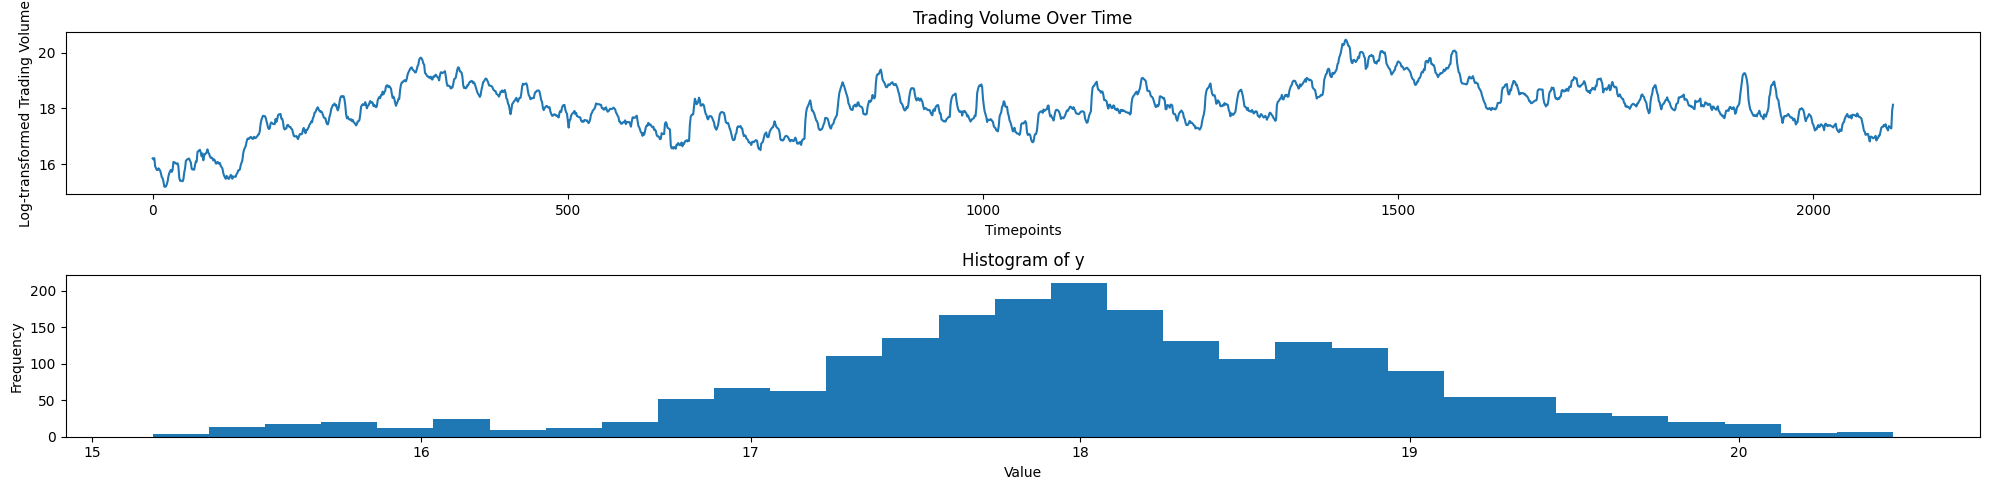

In [8]:
# Apply a rolling average of 7 days to reduce the noisy fluctuations
df_stationary = df.rolling(window=7).mean().dropna()

# Rolling Volatility
# df_stationary = df.rolling(30).std() * np.sqrt(365) * 100

# Extract the target variable
y = df_stationary['Trading Volume (Target Variable)'].to_numpy().reshape(-1, 1)


# ACHIEVE STATIONARITY
"""
Apply differencing to the predictor variables to remove trends and achieve stationarity.
Formula:
diff_x[t] = x[t] - x[t-1]
"""
X = df_stationary.drop('Trading Volume (Target Variable)', axis=1).diff().dropna()

"""
Apply log transformation to the target variable to achieve a more normal and stationary distribution.
- np.log1p is the natural logarithm function applied to (y + 1) to handle zero or negative values.
"""
y = np.log1p(y)


# TEST STATIONARITY
constant_columns = [col for col in X.columns if X[col].nunique() == 1] # Check and remove constant columns
X = X.drop(columns=constant_columns)

def check_stationarity(df_stationary):
    """
    Perform the Augmented Dickey-Fuller (ADF) test on all variables.

    ADF test is a statistical test called a unit root test. The null hypothesis of the
    ADF test is that the time series has a unit root, meaning it is non-stationary. If the p-value
    is less than a significance level (e.g., 0.05), we reject the null hypothesis and conclude that
    the series is stationary.

    Args:
    df_stationary (pd.DataFrame): DataFrame containing the differenced variables to be tested for stationarity.

    Returns:
    None: Prints the result for each variable. If all variables are stationary, prints a corresponding message.
    """
    all_stationary = True
    for variable in df_stationary.columns:
        result = adfuller(df_stationary[variable])
        p_value = result[1]
        if p_value >= 0.05:
            print(f"The variable {variable} is not stationary.\n")
            all_stationary = False

    if all_stationary:
        print("All variables are stationary.")
check_stationarity(X)
check_stationarity(pd.DataFrame(y))

# Turn the training data into a numpy array
X= X.to_numpy()


fig, (ax1, ax2) = plt.subplots (2, 1, figsize=(20, 5))
# Plot Trading Volume (Target Variable)
ax1.plot(y)
ax1.set_title('Trading Volume Over Time')
ax1.set_xlabel('Timepoints')
ax1.set_ylabel('Log-transformed Trading Volume')
# Plot histogram of y
ax2.hist(y, bins='auto')
ax2.set_title('Histogram of y')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
# Calculate the split points
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

# SPLIT INTO TRAINING, VALIDTATION AND TESTDATA
x_train, x_val, x_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# SCALING
"""
MinMaxScaling:
x' = (x - min(x)) / ((max(x) - min(x))
"""
scaler_x = MinMaxScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_val = scaler_x.transform(x_val)
x_test = scaler_x.transform(x_test)

scaler_y = MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# KERNEL PCA FOR DIMENSIONALITY REDUCTION (n_components was determined in a previous run)
"""
Non-linear dimensionality reduction through the use of kernels:

Kernel PCA is an extension of principal component analysis (PCA) using techniques of kernel methods.
Using a kernel, the originally linear operations of PCA are done in a higher-dimensional space with a
non-linear mapping, but still computed as efficiently as PCA.

kernel :
The RBF kernel is a popular kernel function.
It is defined as:

K(x, y) = exp(-gamma * ||x - y||^2)

where gamma is a free parameter that must be set manually. A higher gamma value will
make the decision boundary more dependent on the training points that are close to the
decision boundary, while a lower gamma value makes the decision boundary smoother and
more general, potentially underfitting the training data.

Returns:
-------
X_new : array-like, shape (n_samples, n_components)
Projected data, where n_samples is the number of samples and n_components is the number of components.

"""
kpca = KernelPCA(kernel='rbf', n_components=15)
x_train = kpca.fit_transform(x_train)
x_val = kpca.transform(x_val)
x_test = kpca.transform(x_test)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1467, 15) (314, 15) (315, 15) (1467, 1) (314, 1) (316, 1)


<ipython-input-10-47dfe1ff9c0f>:40: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(pacf_values)), pacf_values, basefmt=" ", use_line_collection=True)


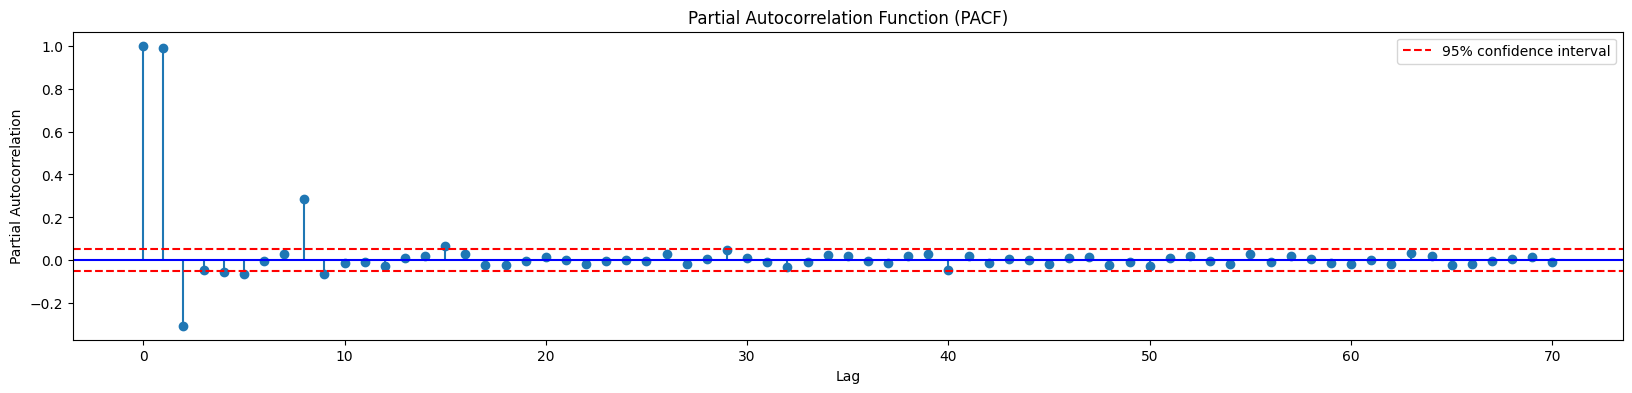

In [10]:
# DETERMINE THE BEST TAU VALUE

# Compute PACF values
pacf_values = pacf(y_train, nlags=70, method='ywm')
"""
    Compute Partial Autocorrelation Function (PACF) values.

    Args:
    y_train (np.ndarray): Training data for the target variable.
    nlags (int): Number of lags to compute PACF for.
    method (str): Method to compute PACF ('ywm' stands for Yule-Walker with bias correction).

    Returns:
    np.ndarray: PACF values.

    Formula:
    1. Compute the mean of the series:
       y_mean = np.mean(y_train)

    2. For each lag k (from 1 to nlags):
       a. Calculate the numerator:
          numerator = np.sum((y_train[k:] - y_mean) * (y_train[:-k] - y_mean))

       b. Calculate the denominator:
          denominator = np.sum((y_train[k:] - y_mean) ** 2)

       c. Compute the partial autocorrelation at lag k:
          phi_kk = numerator / denominator

    Note:
    - The above steps are a simplified version of the Yule-Walker equations used to compute PACF.
    - In practice, the Yule-Walker method involves solving a system of linear equations.
"""

# Significance threshold (95% confidence level)
threshold = 1.96 / np.sqrt(len(y_train))

# Plot PACF values
plt.figure(figsize=(20, 4))
plt.stem(range(len(pacf_values)), pacf_values, basefmt=" ", use_line_collection=True)
plt.axhline(y=threshold, linestyle='--', color='r', label='95% confidence interval')
plt.axhline(y=0, linestyle='-', color='b')
plt.axhline(y=-threshold, linestyle='--', color='r')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.legend()
plt.show()


#### We see that there is autocorrelation up to the TAU'th day

In [11]:
# PARAMS
TAU = 8

# FUNCTION FOR A MULTIVARIATE TIMESERIES
def autoregressive_timeseries(features, target, timesteps):
    """
    Converts ndarray into sequences and timeseries format for autoregressive modeling.
    Uses the past `timesteps` number of rows as input, combining features and past target values,
    and sets the `timesteps + 1`-th target value as the corresponding output.

    Parameters:
    features (ndarray): The predictors, a 2D array where each row is a time step and each column is a feature.
    target (ndarray): The labels, a 1D array.
    timesteps (int): The number of time steps to include in each input sequence.

    Returns:
    tuple: A tuple containing two numpy arrays:
           dataX (ndarray): 2D numpy array where each row contains the combined features and past target values for a sequence of timesteps
           dataY (ndarray): 1D numpy array where each element is the target value that follows the corresponding input sequence in dataX.
    """
    dataX, dataY = [], []
    for i in range(len(features) - timesteps):
        # Combine features and past target values
        x = np.hstack((features[i:(i + timesteps)], target[i:(i + timesteps)].reshape(-1, 1)))
        dataX.append(x)
        dataY.append(target[i + timesteps])  # Output value
    return np.array(dataX), np.array(dataY).reshape(-1)  # Ensure dataY is 1D



# # CREATE THE SEQUENCES
x_train, y_train = autoregressive_timeseries(x_train, y_train, TAU)
x_val, y_val = autoregressive_timeseries(x_val, y_val, TAU)
x_test, y_test = autoregressive_timeseries(x_test, y_test, TAU)


print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(1459, 8, 16) (1459,) (306, 8, 16) (306,) (307, 8, 16) (307,)


## autoregressive Feed Forward Neural Net (FFN)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 8, 30)                510       
                                                                 
 layer_normalization (Layer  (1, 8, 30)                60        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (1, 8, 30)                0         
                                                                 
 dense_1 (Dense)             (1, 8, 30)                930       
                                                                 
 layer_normalization_1 (Lay  (1, 8, 30)                60        
 erNormalization)                                                
                                                                 
 flatten (Flatten)           (1, 240)                  0

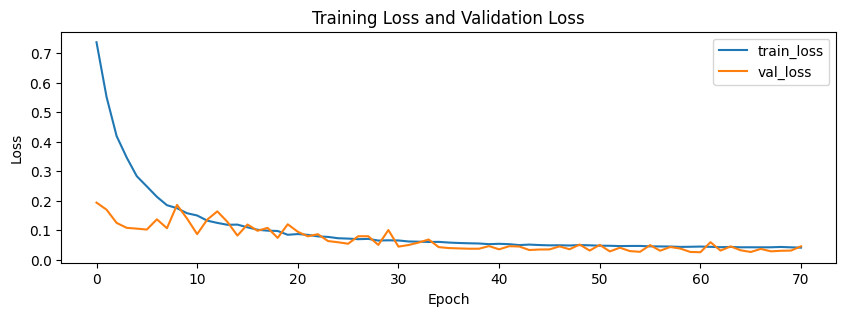

In [12]:
# Seeds for reproducibility
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


ffn = keras.Sequential([

    # FFN layer
    keras.layers.Dense(UNITS, activation="gelu", batch_input_shape=(BATCHSIZE, TAU, x_train.shape[2]), kernel_initializer=keras.initializers.HeNormal(seed=SEED)),
    # Dense: Fully connected layer with e.g. 10 units and activation
    # Gaussian error linear unit (GELU): gelu(x) = x * P(X <= x) where P(X) ~ N(0, 1), i.e. gelu(x) = 0.5 * x * (1 + erf(x / sqrt(2))). GELU weights inputs by their value, rather than gating inputs by their sign as in ReLU.
    # batch_input_shape: shape of the input tensor (Batchsize, Timesteps, Features)
    # HeNormal: draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
    keras.layers.LayerNormalization(),
    # LayerNormalization: Normalizes the activations of the previous layer per example across the feature dimension.Formula: # \hat{x} = (x - μ_layer) / sqrt(σ_layer^2 + ε); y = γ * \hat{x} + β

    # FFN layer
    keras.layers.Dropout(0.5),
    # Dropout: Randomly sets 50% of input units to 0 at each update during training, which helps prevent overfitting.
    keras.layers.Dense(UNITS, activation="gelu", kernel_initializer=keras.initializers.HeNormal(seed=SEED)),
    keras.layers.LayerNormalization(),

    # Output layer
    keras.layers.Flatten(),
    # Flatten: Reshapes the input tensor to get a 1 dimensional output

    keras.layers.Dense(1, activation = "linear", kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))
    # Linear Activation: f(x)=w⋅x+b.
    # Glorot Unifrom: draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).
])


# Compile the model
ffn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= LR),
     loss= 'mean_absolute_error' # loss = mean(abs(y_true - y_pred))
    )



# Define the EarlyStopping callback to restore the best model weights based on validation loss
early_stopping_ffn = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= PATIENCE,
    restore_best_weights=True, # Saves the best parameter weights on the validation data, instead of the weights at the last epoch
    mode='min',
    verbose=0
)


# Train the model
ffn_history = ffn.fit(x_train,y_train,
                      validation_data= (x_val, y_val),
                      epochs=EPOCHS,
                      batch_size= BATCHSIZE,
                      callbacks=[early_stopping_ffn],
                      verbose=0)

# EVALUATION OF THE TRAINING
ffn.summary()

plt.figure(figsize=(10, 3))
plt.plot(ffn_history.history['loss'], label='train_loss')
plt.plot(ffn_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss and Validation Loss')

print("Best Validation Epoch-Loss:", early_stopping_ffn.best)

## SIMPLE stateful RNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (1, 8, 30)                1410      
                                                                 
 layer_normalization_2 (Lay  (1, 8, 30)                60        
 erNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (1, 8, 30)                0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, 30)                   1830      
                                                                 
 layer_normalization_3 (Lay  (1, 30)                   60        
 erNormalization)                                                
                                                                 
 dense_3 (Dense)             (1, 1)                   

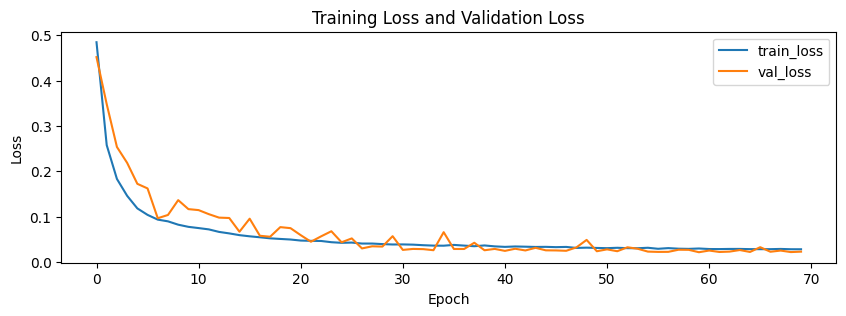

In [13]:
# Seeds for reproducibility
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# One layer RNN model
rnn = keras.Sequential([

    # RNN layer
    keras.layers.SimpleRNN(UNITS, activation="tanh", batch_input_shape=(BATCHSIZE, TAU, x_train.shape[2]), stateful =True, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=SEED)),
    # Tanh: Hyperbolic tangent activation function: tanh(x) = sinh(x) / cosh(x), i.e. tanh(x) = ((exp(x) - exp(-x)) / (exp(x) + exp(-x))).
    # stateful (bool): When set to True, this parameter ensures that the states for the recurrent layers are maintained across different batches, which is useful for stateful RNNs where the sequences are longer than the batch size.
    # return_sequences (bool): makes the recurrent layer return the full sequence of outputs for each input sequence, instead of only the output of the last time step.
    # GlorotNormal: Draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor.
    keras.layers.LayerNormalization(),

    # RNN layer
    keras.layers.Dropout(0.5),
    keras.layers.SimpleRNN(UNITS, activation="tanh", stateful =True, return_sequences=False, kernel_initializer=keras.initializers.GlorotNormal(seed=SEED)),
    keras.layers.LayerNormalization(),

    # Output layer
    keras.layers.Dense(1, activation = "linear", kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))
    # Glorot Unifrom: draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units)
    ])

# Compile the model
rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
     loss= 'mean_absolute_error' # loss = mean(abs(y_true - y_pred))
)

# Define the EarlyStopping callback to restore the best model weights based on validation loss
early_stopping_rnn = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# Train the model
rnn_history = rnn.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=EPOCHS,
                            batch_size=BATCHSIZE,
                            callbacks=[early_stopping_rnn],
                            verbose = 0)

# EVALUATION OF THE TRAINING
rnn.summary()

# Plot the training and validation loss
plt.figure(figsize=(10, 3))
plt.plot(rnn_history.history['loss'], label='train_loss')
plt.plot(rnn_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss and Validation Loss')

print("Best Validation Loss:", early_stopping_rnn.best)

## stateful GRU

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1, 8, 30)                4320      
                                                                 
 layer_normalization_4 (Lay  (1, 8, 30)                60        
 erNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (1, 8, 30)                0         
                                                                 
 gru_1 (GRU)                 (1, 30)                   5580      
                                                                 
 layer_normalization_5 (Lay  (1, 30)                   60        
 erNormalization)                                                
                                                                 
 dense_4 (Dense)             (1, 1)                   

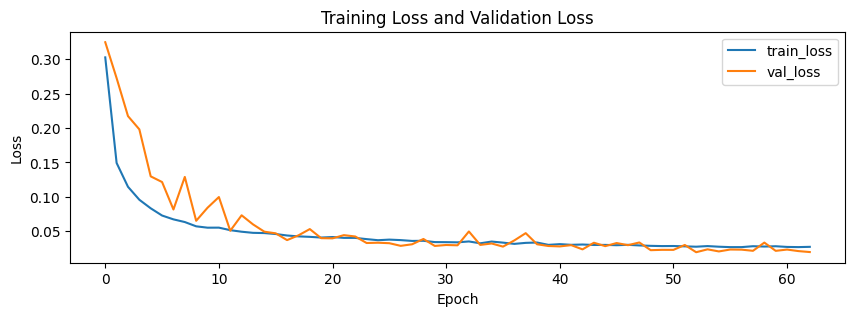

In [14]:
# Seeds for reproducibility
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# One layer gru model
gru = keras.Sequential([

    # GRU layer
    keras.layers.GRU(UNITS, activation="tanh", batch_input_shape=(BATCHSIZE, TAU, x_train.shape[2]), stateful =True, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=SEED)),
    keras.layers.LayerNormalization(),

    #GRU layer
    keras.layers.Dropout(0.5),
    keras.layers.GRU(UNITS, activation="tanh", stateful =True, return_sequences=False, kernel_initializer=keras.initializers.GlorotNormal(seed=SEED)),
    keras.layers.LayerNormalization(),

    # Output layer
    keras.layers.Dense(1, activation = "linear", kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))
])

# Compile the model
gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
     loss= 'mean_absolute_error' # loss = mean(abs(y_true - y_pred))
)

# Define the EarlyStopping callback to restore the best model weights based on validation loss
early_stopping_gru = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    mode='min',
    verbose=0
)

# Train the model
gru_history = gru.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=EPOCHS,
                            batch_size=BATCHSIZE,
                            callbacks=[early_stopping_gru],
                            verbose = 0)

# EVALUATION OF THE TRAINING
gru.summary()

# Plot the training and validation loss
plt.figure(figsize=(10, 3))
plt.plot(gru_history.history['loss'], label='train_loss')
plt.plot(gru_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss and Validation Loss')

print("Best Validation Loss:", early_stopping_gru.best)

## stateful LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 30)                   5640      
                                                                 
 layer_normalization_6 (Lay  (1, 30)                   60        
 erNormalization)                                                
                                                                 
 dense_5 (Dense)             (1, 1)                    31        
                                                                 
Total params: 5731 (22.39 KB)
Trainable params: 5731 (22.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Best Validation Epoch-Loss: 0.055472467094659805


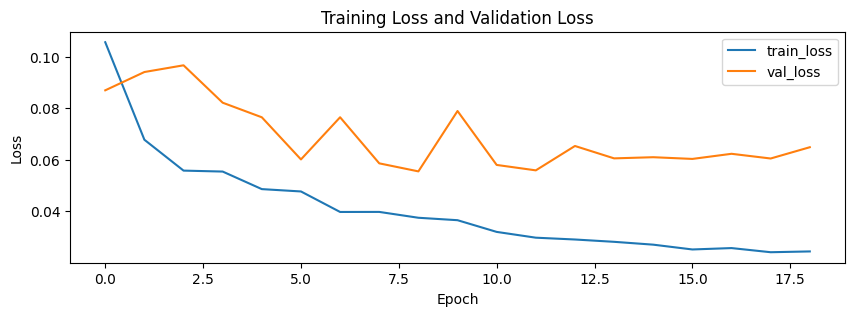

In [15]:
# Seeds for reproducibility
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


# Define the model
lstm = keras.Sequential([

    # LSTM layer
    keras.layers.LSTM(UNITS, activation="tanh", batch_input_shape=(BATCHSIZE, TAU, x_train.shape[2]), return_sequences= False, stateful = True, kernel_initializer=keras.initializers.GlorotNormal(seed=SEED)),
    keras.layers.LayerNormalization(),

    # # LSTM layer -> removed because more layers led to worse performance
    # keras.layers.Dropout(0.5),
    # keras.layers.LSTM(UNITS, activation="tanh", return_sequences= False, stateful = True, kernel_initializer=keras.initializers.GlorotNormal(seed=SEED)),
    # keras.layers.LayerNormalization(),

    # Output layer
    keras.layers.Dense(1, activation = "linear", kernel_initializer=keras.initializers.GlorotUniform(seed=SEED))
])

# Compile the model
lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= LR), # Needed a lower LR then the rest to pick up a signal
     loss= 'mean_absolute_error' # loss = mean(abs(y_true - y_pred))
)

# Early stopping callback
early_stopping_lstm = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= PATIENCE,
    restore_best_weights=True,
    verbose=0
)


# Fit the model
lstm_history = lstm.fit(
    x_train, y_train,
    epochs= EPOCHS,
    batch_size= BATCHSIZE,
    validation_data=(x_val, y_val),
    shuffle=False,
    callbacks=[early_stopping_lstm],
    verbose=0
)

# EVALUATION
lstm.summary()

plt.figure(figsize=(10, 3))
plt.plot(lstm_history.history['loss'], label='train_loss')
plt.plot(lstm_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss and Validation Loss')

# EVALUATION OF THE TRAINING
print("Best Validation Epoch-Loss:", early_stopping_lstm.best)


# Evaluation

### Original Target

FFN - RMSE: 15667239.128454115, MAE: 9783056.539432293, MSE: 245462381908163.66
RNN - RMSE: 11425779.654395847, MAE: 8099221.602196375, MSE: 130548440710806.1
GRU - RMSE: 10575022.387152836, MAE: 7573037.438939046, MSE: 111831098488783.64
LSTM - RMSE: 40702972.82174842, MAE: 34730691.40184273, MSE: 1656731996527990.8


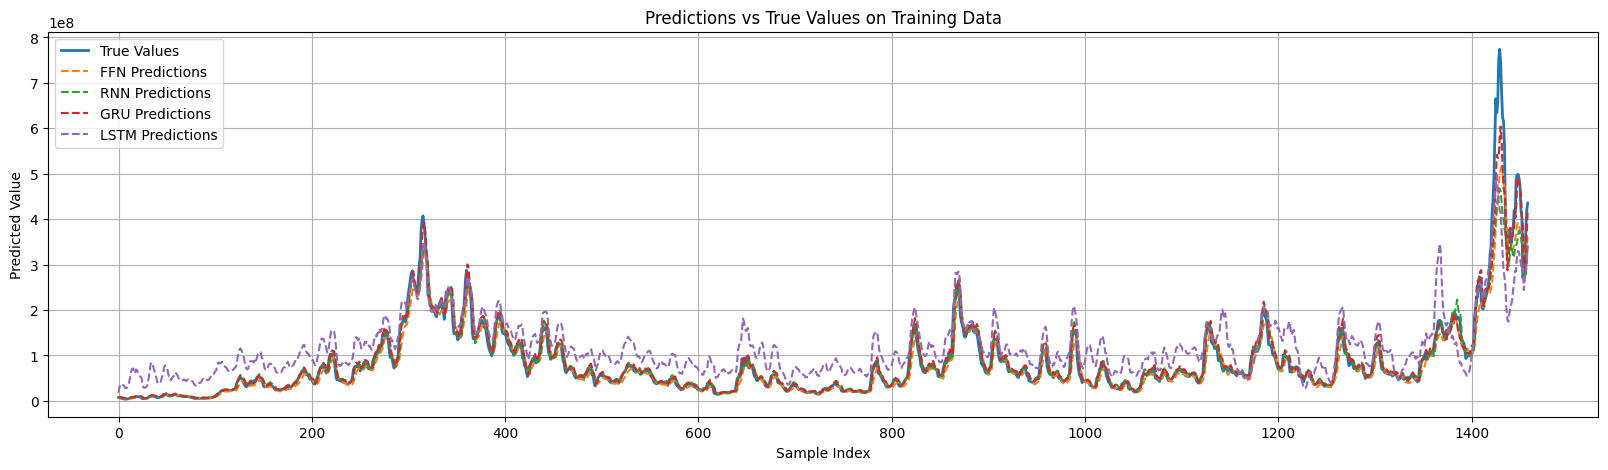

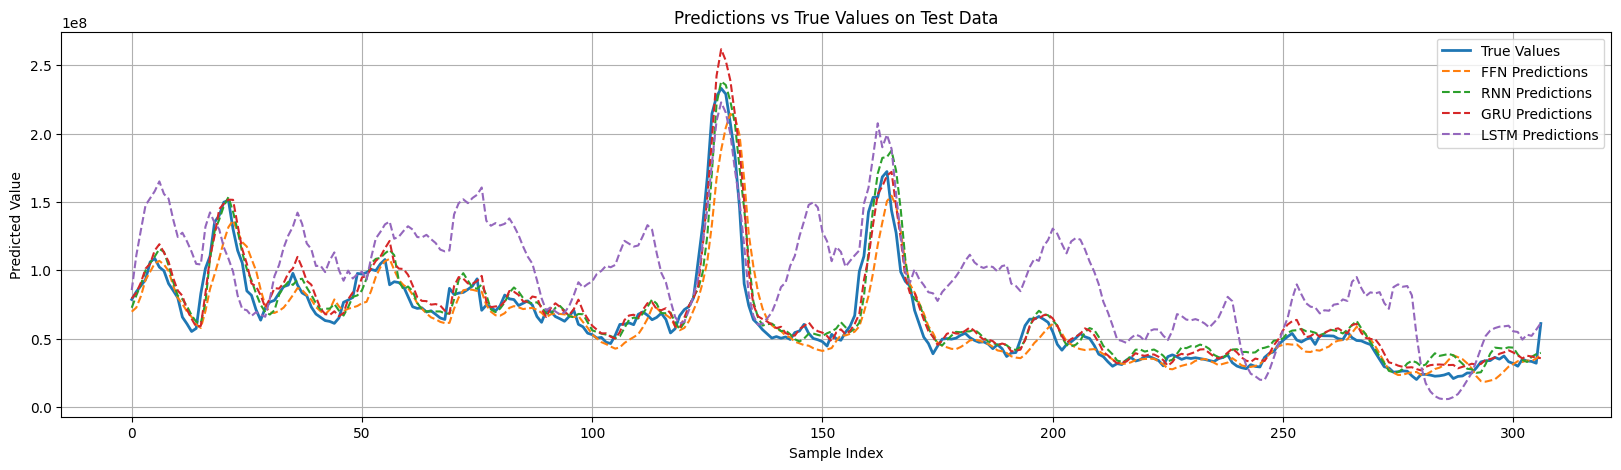

In [16]:
# Dictionary for the training and one for the test data to save the predicted Values of each Model
pred_train = {}
pred_test = {}


def inverse_transformation_for_target(pred, scaler_y):
    """
    Invert the MinMaxScaler and Logarithmic transformation applied to predictions.

    Args:
    pred (numpy array): Array containing the transformed predictions.
    scaler_y (MinMaxScaler): Scaler used to originally transform the target variable.
    original_data (pd.Series): Original data series before any transformation.

    Returns:
    numpy array: Inverted predictions.

    Formula:
    1. Invert MinMaxScaler transformation:
    X = pred * (X_max - X_min) + X_min

    2. Invert log-transformation:
    X_inverted = exp(X)
    """
    # Invert MinMaxScaler transformation
    inverted_pred = scaler_y.inverse_transform(pred.reshape(-1, 1)).reshape(-1)
    # Invert log trafo
    inverted_pred = np.exp(inverted_pred)

    return inverted_pred

# Reverse Transform: y_pred_org = (y_pred * range) + min
pred_train["true"] = inverse_transformation_for_target(y_train, scaler_y)
pred_test["true"] = inverse_transformation_for_target(y_test, scaler_y)

#FFN
pred_train["FFN"] = inverse_transformation_for_target(ffn.predict(x_train, verbose=0, batch_size=BATCHSIZE), scaler_y)
pred_test["FFN"] = inverse_transformation_for_target(ffn.predict(x_test, verbose=0, batch_size=BATCHSIZE), scaler_y)

#RNN
pred_train["RNN"] = inverse_transformation_for_target(rnn.predict(x_train, verbose=0, batch_size=BATCHSIZE), scaler_y)
pred_test["RNN"] = inverse_transformation_for_target(rnn.predict(x_test, verbose=0, batch_size=BATCHSIZE), scaler_y)

#GRU
pred_train["GRU"] = inverse_transformation_for_target(gru.predict(x_train, verbose=0, batch_size=BATCHSIZE), scaler_y)
pred_test["GRU"] = inverse_transformation_for_target(gru.predict(x_test, verbose=0, batch_size=BATCHSIZE), scaler_y)

#LSTM
pred_train["LSTM"] = inverse_transformation_for_target(lstm.predict(x_train, verbose=0, batch_size=BATCHSIZE), scaler_y)
pred_test["LSTM"] = inverse_transformation_for_target(lstm.predict(x_test, verbose=0, batch_size=BATCHSIZE), scaler_y)


# Metrics on the Test data
def calculate_metrics(true_values, predicted_values):
    errors = true_values - predicted_values
    mse = np.mean(errors ** 2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(errors))
    return rmse, mae, mse

# Store metric values in a dictionary
metrics_values = {
    "FFN": calculate_metrics(pred_test["true"], pred_test["FFN"]),
    "RNN": calculate_metrics(pred_test["true"], pred_test["RNN"]),
    "GRU": calculate_metrics(pred_test["true"], pred_test["GRU"]),
    "LSTM": calculate_metrics(pred_test["true"], pred_test["LSTM"])
}

for model, metrics in metrics_values.items():
    print(f"{model} - RMSE: {metrics[0]}, MAE: {metrics[1]}, MSE: {metrics[2]}")



# Plot for training data
plt.figure(figsize=(20, 5))

plt.plot(pred_train['true'], label='True Values', linewidth=2)
plt.plot(pred_train['FFN'], label='FFN Predictions', linestyle='--')
plt.plot(pred_train['RNN'], label='RNN Predictions', linestyle='--')
plt.plot(pred_train['GRU'], label='GRU Predictions', linestyle='--')
plt.plot(pred_train['LSTM'], label='LSTM Predictions', linestyle='--')
plt.title('Predictions vs True Values on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()


# Plot for test data
plt.figure(figsize=(20, 5))
plt.plot(pred_test['true'], label='True Values', linewidth=2)
plt.plot(pred_test['FFN'], label='FFN Predictions', linestyle='--')
plt.plot(pred_test['RNN'], label='RNN Predictions', linestyle='--')
plt.plot(pred_test['GRU'], label='GRU Predictions', linestyle='--')
plt.plot(pred_test['LSTM'], label='LSTM Predictions', linestyle='--')
plt.title('Predictions vs True Values on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

## Recommended Literature on the Topic

Timeseries-analysis:
- https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide
- https://mlpills.dev/time-series/step-by-step-guide-to-multivariate-time-series-forecasting-with-var-models/

Recurrent Neural Nets
- https://humboldt-wi.github.io/blog/research/information_systems_1819/02lstmgruandbeyond/
- https://danijar.com/tips-for-training-recurrent-neural-networks/